<a href="https://colab.research.google.com/github/kevinajordan/Deep-Learning-Projects/blob/master/Facial%20Keypoint%20Detection/tf_Facial_Keypoints_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Keypoint Detection

Inspired by Udacity's Computer Vision Nanodegree project 1 [Udacity FKP GitHub Page](https://github.com/udacity/P1_Facial_Keypoints), with some modifications. This project will be all about defining and training a convolutional neural network to perform facial keypoint detection, and using computer vision techniques to transform images of faces.  The first step in any challenge like this will be to load and visualize the data you'll be working with. 

Let's take a look at an example of an image with corresponding facial keypoints.

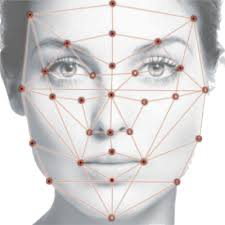

Facial keypoints (also called facial landmarks) are the small magenta dots shown on each of the faces in the image above. In each training and test image, there is a single face and **68 keypoints, with coordinates (x, y), for that face**.  These keypoints mark important areas of the face: the eyes, corners of the mouth, the nose, etc. These keypoints are relevant for a variety of tasks, such as face filters, emotion recognition, pose recognition, and so on. Here they are, numbered, and you can see that specific ranges of points match different portions of the face.


![alt text](https://lh6.googleusercontent.com/kb_PrLG_1k5EIr32SuHvSY01b5zmCrx84QQr62POFA-xas5s-NmvbQLZRAKOzMKtRcuCGl-Ha4wGJIpiR_SF8C-3QIes_IzIw2R8CVykalzkNilUXuWFuLk5Dxrqiky2xRW4LxVNCZo)



In the next section let's get into the data loading and pre-processing.


## EDA - Load, Visualize, and Understand The Data

The dataset we'll be working with for this project is the [YouTube Faces Dataset](https://www.cs.tau.ac.il/~wolf/ytfaces/).

You'll need to load in the images of faces and their keypoints and visualize them. These videos have been fed through some processing steps and turned into sets of image frames containing one face and the associated keypoints.



#### Training and Testing Data

This facial keypoints dataset consists of 5770 color images. All of these images are separated into either a training or a test set of data.

* 3462 of these images are training images, for you to use as you create a model to predict keypoints.
* 2308 are test images, which will be used to test the accuracy of your model.

The information about the images and keypoints in this dataset are summarized in CSV files, which we can read in using `pandas`. Let's read the training CSV and get the annotations in an (N, 2) array where N is the number of keypoints and 2 is the dimension of the keypoint coordinates (x, y).


In [0]:
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

--2019-09-21 21:30:18--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.86.69
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.86.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip’

train-test-data.zip 100%[===================>] 322.93M  93.5MB/s    in 3.6s    

2019-09-21 21:30:22 (89.4 MB/s) - ‘/data/train-test-data.zip’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip
   creating: /data/test/
  inflating: /data/test/Abdel_Aziz_Al-Hakim_00.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_01.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_10.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_11.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_40.jpg  
  inflating: /data/test/Abdel_Aziz_Al-Hakim_41.jpg  
  inflating: /data/test/Abdullah_Gul_10.j

In [0]:
# let's look in our data folder we just created to see what Udacity gives us.
!ls -la /data

total 334128
drwxr-xr-x 4 root root      4096 Sep 21 14:56 .
drwxr-xr-x 1 root root      4096 Sep 21 14:56 ..
drwxr-xr-x 2 root root    114688 Apr 26  2018 test
-rw-r--r-- 1 root root    590606 Apr 26  2018 test_frames_keypoints.csv
drwxr-xr-x 2 root root    155648 Apr 26  2018 training
-rw-r--r-- 1 root root   2653447 Apr 26  2018 training_frames_keypoints.csv
-rw-r--r-- 1 root root 338613624 May  2  2018 train-test-data.zip


In [0]:
# import the required libraries
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.preprocessing.image import load_img, save_img, img_to_array
import cv2

Using TensorFlow backend.


In [0]:
import os
os.chdir('/data')
os.getcwd()
os.listdir('.')

['test',
 'training',
 'test_frames_keypoints.csv',
 'training_frames_keypoints.csv',
 'train-test-data.zip']

In [0]:
key_pts_frame = pd.read_csv('/data/training_frames_keypoints.csv')
test_frames = pd.read_csv('/data/test_frames_keypoints.csv')

In [0]:
print("This is the training csv file:")
print(key_pts_frame.head())
print("This is the test csv file: ")
print(test_frames.head())

This is the training csv file:
                   Unnamed: 0     0     1     2  ...   132    133   134    135
0           Luis_Fonsi_21.jpg  45.0  98.0  47.0  ...  81.0  122.0  77.0  122.0
1       Lincoln_Chafee_52.jpg  41.0  83.0  43.0  ...  83.0  122.0  79.0  122.0
2       Valerie_Harper_30.jpg  56.0  69.0  56.0  ...  75.0  105.0  73.0  105.0
3         Angelo_Reyes_22.jpg  61.0  80.0  58.0  ...  91.0  139.0  85.0  136.0
4  Kristen_Breitweiser_11.jpg  58.0  94.0  58.0  ...  88.0  122.0  84.0  122.0

[5 rows x 137 columns]
This is the test csv file: 
                   Unnamed: 0     0     1     2  ...   132    133   134    135
0     James_Wolfensohn_00.jpg  25.0  44.0  25.0  ...  39.0   65.0  38.0   65.0
1       Valerie_Harper_30.jpg  55.0  62.0  52.0  ...  75.0  104.0  70.0  104.0
2  Kristen_Breitweiser_11.jpg  60.0  88.0  60.0  ...  94.0  117.0  89.0  117.0
3       Elizabeth_Dole_31.jpg  41.0  96.0  43.0  ...  96.0  122.0  94.0  122.0
4             Kit_Bond_20.jpg  35.0  67.0  37.0 

Let's look at a single image's shape and the facial keypoints associated with it.

In [0]:
n = 0

# What pandas function can I use to grab the image name out of the first column?
im_name = key_pts_frame.iloc[n,0]

# Grab the key_point values, convert them to a numpy.ndarray object. as_matrix() is deprecated.
key_points = key_pts_frame.iloc[n,1:].values

# convert the values to data type 'float' and give me a listing of the key points in [x,y] format.
#key_pts = key_pts.astype('float').reshape(-1, 2)
key_points = key_points.astype('float').reshape(-1, 2)

print('Image name: ', im_name)
print('Landmarks shape: ', key_points.shape)
print('First 4 key pts: {}'.format(key_points[:4]))

Image name:  Luis_Fonsi_21.jpg
Landmarks shape:  (68, 2)
First 4 key pts: [[ 45.  98.]
 [ 47. 106.]
 [ 49. 110.]
 [ 53. 119.]]


In [0]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    # This will display the image in a 'blueish' tint
    #plt.imshow(image)

    # This will display the image in grayscale like you intended. 
    plt.imshow(image, cmap =plt.get_cmap('gray'))
    
    # second, draw the key points on top of the plotted image using matplotlib
    plt.scatter(key_pts[:, 0], key_pts[:, 1], marker='.', c='m')
    plt.show()

In [0]:
image = cv2.imread(os.path.join('/data/training/', im_name))
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
show_keypoints(image, key_points)

NameError: ignored

### Applying Resizing

We'll create a resizing function first to resize our image height and width and the keypoint coordinates.

In [0]:
def resize_img(test, image_name, key_pts, new_size):
  if test == True:
    org_image = cv2.imread(os.path.join('/data/test/', image_name))
  else:
    org_image = cv2.imread(os.path.join('/data/training/', image_name))

  # convert image to grayscale
  org_h = org_image.shape[0]
  org_w = org_image.shape[1]

  #img_rs = load_img(os.path.join('/data/training/', image_name), color_mode='grayscale', target_size=(new_size, new_size))
  #img_cv = cv2.imread(os.path.join('/data/training/', image_name))
  img_cv = cv2.cvtColor(org_image, cv2.COLOR_RGB2GRAY)
  img_cv = cv2.resize(img_cv, (224, 224))
  new_h = img_cv.shape[0]
  new_w = img_cv.shape[1]   
  #img_rs = img_to_array(img_rs)

  if (len(img_cv.shape)==2):
    img_cv = img_cv.reshape(img_cv.shape[0], img_cv.shape[1], 1)

  # convert the pixel values to floats from integers.
  img_cv = img_cv.astype(np.float32)

  # re-size the pts, too
  key_pts = key_pts * [new_w / org_w, new_h / org_h]
  
  return img_cv, key_pts

### Testing OpenCV - loading images and converting to grayscale

In [0]:
img_name = key_pts_frame.iloc[2,0]
org_image = cv2.imread(os.path.join('/data/training/', img_name))
img_cv = cv2.cvtColor(org_image, cv2.COLOR_RGB2GRAY)
img_cv = cv2.resize(img_cv, (224, 224))
img_cv = img_cv.astype('float').reshape(img_cv.shape[0], img_cv.shape[1], 1)

In [0]:
print(img_cv.shape)
print(type(img_cv))

(224, 224, 1)
<class 'numpy.ndarray'>


In [0]:
img_cv

array([[[174.],
        [177.],
        [180.],
        ...,
        [ 41.],
        [ 40.],
        [ 36.]],

       [[176.],
        [179.],
        [181.],
        ...,
        [ 42.],
        [ 41.],
        [ 38.]],

       [[177.],
        [180.],
        [183.],
        ...,
        [ 43.],
        [ 43.],
        [ 42.]],

       ...,

       [[118.],
        [118.],
        [115.],
        ...,
        [ 40.],
        [ 41.],
        [ 41.]],

       [[120.],
        [117.],
        [114.],
        ...,
        [ 46.],
        [ 46.],
        [ 44.]],

       [[119.],
        [119.],
        [119.],
        ...,
        [ 53.],
        [ 48.],
        [ 40.]]])

### Testing Keras - loading images and converting to grayscale
Keras uses PIL

In [0]:
img_name = key_pts_frame.iloc[2,0]
img_resc = load_img(os.path.join('/data/training/', img_name), color_mode='grayscale', target_size=(224, 224))
img_resc = img_to_array(img_resc)
print(img_rs.shape)
print(img_rs[0])

In [0]:
key_pts = key_pts_frame.iloc[n,1:].values
key_pts = key_pts.astype('float').reshape(-1,2)

In [0]:
image, key_pts = resize_img(image_name, key_pts, 224)

In [0]:
plt.figure(figsize=(5, 5))
show_keypoints(image, key_pts)

In [0]:
image = img_to_array(image)
print(image.shape)

In [0]:
print(image)

In [0]:
if(len(image.shape) == 2):
  print('adding a dimension')
  image = expand_dims(image, axis=2)

## Creating Datasets


###Create Training Dataset

In [0]:
image_list = []
key_pts_list = []

for n in range(len(key_pts_frame)):
  image_name = key_pts_frame.iloc[n, 0]

  # Grab the keypoints values and reshape them as [x,y]
  key_pts = key_pts_frame.iloc[n, 1:].values
  key_pts = key_pts.astype('float').reshape(-1, 2)
  
  # Apply resizing to images and keypoints
  image, key_pts = resize_img(False, image_name, key_pts, 224)
  
  # Create a sample as a dictionary of image and keypoints. Append this to the samples list created above.
  image_list.append(image)
  key_pts_list.append(key_pts)

In [0]:
X_train = np.array(image_list,dtype = 'float')
X_train.shape

(3462, 224, 224, 1)

In [0]:
# rescale pixel values to be between [0, 1]
X_train = X_train/255.0

In [0]:
# verify the rescaling of the pixel values
print(X_train.min())
print(X_train.max())

0.0
1.0


In [0]:
y_train = np.array(key_pts_list,dtype = 'float')

In [0]:
# normalize the keypoints
y_train = (y_train - 112.0)/112.0
print(y_train.min())
print(y_train.max())
print(y_train.shape)

-1.1974248927038627
1.03
(3462, 68, 2)


In [0]:
# We are predicting 136 coordinate values (key points). So we need to reshape the keypoints from [68, 2] back to [136, ]
y_train = y_train.reshape(-1, 68 * 2)

###Create Test Set

In [0]:
test_image_list = []
test_key_pts_list = []

for n in range(len(test_frames)):
  image_name = test_frames.iloc[n, 0]

  # Grab the keypoints values and reshape them as [x,y]
  key_pts = test_frames.iloc[n, 1:].values
  key_pts = key_pts.astype('float').reshape(-1, 2)
  
  # Apply resizing to images and keypoints
  image, key_pts = resize_img(True, image_name, key_pts, 224)
  
  # Create a sample as a dictionary of image and keypoints. Append this to the samples list created above.
  test_image_list.append(image)
  test_key_pts_list.append(key_pts)

In [0]:
X_test = np.array(test_image_list,dtype = 'float')
X_test.shape

(770, 224, 224, 1)

If your dataset is not of the right shape, you can reshape it to the right dimensions. Example code is below:

X_train = X_train.reshape(-1,224,224,1)

In [0]:
X_test = X_test/255.0

In [0]:
y_test = np.array(test_key_pts_list,dtype = 'float')

In [0]:
y_test = (y_test - 112.0)/112.0
print(y_test.min())
print(y_test.max())
print(y_test.shape)

-0.9578947368421052
0.9600000000000001
(770, 68, 2)


In [0]:
y_test = y_test.reshape(-1, 68 * 2)
print(y_test.shape)

(770, 136)


# Create Model Architecture

For this lesson, as a baseline, reproduce the model architecture and performance documented in this research paper:

[NamishNet](https://arxiv.org/pdf/1710.00977.pdf)

Recall that CNN's are defined by a few types of layers:

* Convolutional layers
* Maxpooling layers
* Fully-connected layers

## Model 1

In [0]:
# Create your neural network

from keras import models 
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten

model = models.Sequential()

# 1st Conv layer
model.add(Conv2D(32, (5,5), activation='relu', input_shape=(224,224 ,1)))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.1))

# 2nd Conv layer
model.add(Conv2D(64, (4,4), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.2))

# 3rd Conv layer
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))

# 4th Conv layer
model.add(Conv2D(256, (2,2), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.4))

# Flatten from 3D to 1D Tensor
model.add(Flatten())

# 1st fully connected (Dense) layer
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))

# 2nd fully connected (Dense) layer
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.6))

# output layer
model.add(Dense(136))
          
# Print Model Summary
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 220, 220, 32)      832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 107, 107, 64)      32832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 53, 53, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 53, 53, 64)        0         


In [0]:
# model 1 - compile your neural network
from keras import optimizers
# since we are doing prediction, mean squared error will be our loss. The values for the optimizer are pulled from the paper.
model.compile(loss='mse', optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8), metrics=['mse','acc'])

NameError: ignored

## Model 2

In [0]:
from keras.layers.normalization import BatchNormalization
from keras import models 
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten

model2 = models.Sequential()
model2.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(224,224,1)))
model2.add(Dropout(0.1))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode="valid"))
model2.add(BatchNormalization())

model2.add(Conv2D(32, 5, 5,activation="relu"))
# model.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode="valid"))
model2.add(Dropout(0.2))
model2.add(BatchNormalization())

model2.add(Conv2D(64, 5, 5,activation="relu"))
# model.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode="valid"))
model2.add(BatchNormalization())

model2.add(Conv2D(128, 3, 3,activation="relu"))
# model.add(Activation("relu"))
model2.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode="valid"))
model2.add(Dropout(0.4))
model2.add(BatchNormalization())

model2.add(Flatten())

model2.add(Dense(1000, activation="relu"))
model2.add(Dropout(0.1))

model2.add(Dense(1000, activation="relu"))
model2.add(Dropout(0.1))

model2.add(Dense(136))
model2.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), activation="relu")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update you

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      80        
_________________________________________________________________
dropout_1 (Dropout)          (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 16)      64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 32)      12832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 54, 54, 32)       

In [0]:
# model 2- compile network
from keras import optimizers

model2.compile(loss='mse', optimizer='adam', metrics=['mae'])

## Using Keras Image Data Generator

The ImageDataGenerator can be used for data pre-processing and data augmentation (flips, rotations, zooms, shears, etc.)

Below we are going to us it to center and normalize our training data (image pixel values in X_train).

In [0]:
from keras.preprocessing.image import ImageDataGenerator

print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
train_datagen = ImageDataGenerator(
    featurewise_center=True,  # set input mean to 0 over the dataset
    featurewise_std_normalization=True,  # divide inputs by std of the dataset
    data_format="channels_last"
    # fraction of images reserved for validation (strictly between 0 and 1)
    #validation_split=0.3
    )

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
train_datagen.fit(X_train)


Using real-time data augmentation.


## Training the Network

First lets create callbacks and Early Stopper

In [0]:
from keras.callbacks import EarlyStopping
earlystopper = EarlyStopping(monitor='loss', patience=20, verbose=0)

### Model 1 Training

In [0]:
model.fit(X_train,y_train,epochs = 10,batch_size = 256,validation_split = 0.2)

In [0]:
# train your neural network
# Fit the model on the batches generated by datagen.flow().

model.fit_generator(train_datagen.flow(X_train, y_train,
                                 batch_size=256),
                    epochs=50,
                    workers=4)


Epoch 1/20
14/14 [==============================] - 28s 2s/step - loss: 0.0729 - acc: 0.0393
Epoch 2/20
14/14 [==============================] - 14s 1s/step - loss: 0.0206 - acc: 0.1051
Epoch 3/20
14/14 [==============================] - 14s 1s/step - loss: 0.0159 - acc: 0.1534
Epoch 4/20
14/14 [==============================] - 14s 1s/step - loss: 0.0142 - acc: 0.1934
Epoch 5/20
14/14 [==============================] - 14s 1s/step - loss: 0.0137 - acc: 0.2141
Epoch 6/20
14/14 [==============================] - 14s 1000ms/step - loss: 0.0133 - acc: 0.2379
Epoch 7/20
14/14 [==============================] - 14s 1000ms/step - loss: 0.0131 - acc: 0.2616
Epoch 8/20
14/14 [==============================] - 14s 998ms/step - loss: 0.0130 - acc: 0.2849
Epoch 9/20
14/14 [==============================] - 14s 999ms/step - loss: 0.0128 - acc: 0.2799
Epoch 10/20
14/14 [==============================] - 14s 1000ms/step - loss: 0.0127 - acc: 0.2971
Epoch 11/20
14/14 [==============================]

### Model 2 Training

In [0]:
history2 = model2.fit_generator(train_datagen.flow(X_train, y_train,
                                 batch_size=256),
                    epochs=75,
                    callbacks = [earlystopper],
                    workers=4)

Epoch 1/75
14/14 [==============================] - 18s 1s/step - loss: 0.2517 - mean_absolute_error: 0.3241
Epoch 2/75
14/14 [==============================] - 9s 658ms/step - loss: 0.0317 - mean_absolute_error: 0.1402
Epoch 3/75
14/14 [==============================] - 9s 660ms/step - loss: 0.0215 - mean_absolute_error: 0.1143
Epoch 4/75
14/14 [==============================] - 9s 659ms/step - loss: 0.0175 - mean_absolute_error: 0.1025
Epoch 5/75
14/14 [==============================] - 9s 662ms/step - loss: 0.0153 - mean_absolute_error: 0.0954
Epoch 6/75
14/14 [==============================] - 9s 663ms/step - loss: 0.0142 - mean_absolute_error: 0.0913
Epoch 7/75
14/14 [==============================] - 9s 661ms/step - loss: 0.0129 - mean_absolute_error: 0.0867
Epoch 8/75
14/14 [==============================] - 9s 661ms/step - loss: 0.0118 - mean_absolute_error: 0.0823
Epoch 9/75
14/14 [==============================] - 9s 661ms/step - loss: 0.0107 - mean_absolute_error: 0.0784
Epo

In [0]:
history2.history

NameError: ignored

In [0]:
ypred = model2.predict(X_test)

In [0]:
type(ypred[0])

numpy.ndarray

In [0]:
y_pred_0 = ypred[0]
# un-normalizing
y_pred_0 = y_pred_0 * 112.0 + 112

In [0]:
y_pred_0 = y_pred_0.reshape(68, 2)

In [0]:
t_im_name_0 = test_frames.iloc[0,0]
t_im_0 = cv2.imread(os.path.join('/data/test/', image_name))
t_im_0 = cv2.cvtColor(t_im_0, cv2.COLOR_RGB2GRAY)
t_im_0 = cv2.resize(t_im_0, (224, 224))

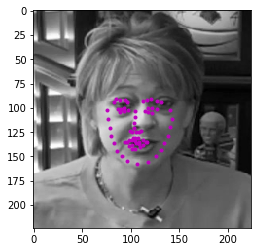

In [0]:
show_keypoints(t_im_0, y_pred_0)

### Visualize Predicted Key points

In [0]:
def visualize_output(pred_keypts, batch_size=10):
  for i in range(batch_size):
    plt.figure(figsize=(20,10))
    ax = plt.subplot(1, batch_size, i+1)

    image_name = test_frames.iloc[i, 0]
    image = cv2.imread(os.path.join('/data/test/', image_name))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image, (224, 224))

    predicted_key_pts = pred_keypts[i]

    # undo normalization of keypoints
    predicted_key_pts = predicted_key_pts * 112.0 + 112

    # reshaping keypoints numpy array back to x,y pairs
    predicted_key_pts = predicted_key_pts.reshape(68, 2)
    
    # call show_keypoints
    show_keypoints(image, predicted_key_pts)
    plt.axis('off')
  plt.show()

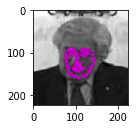

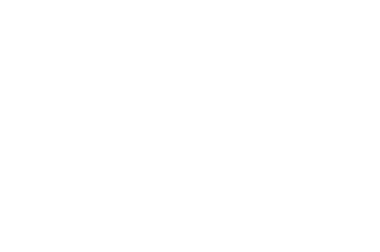

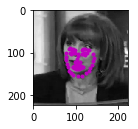

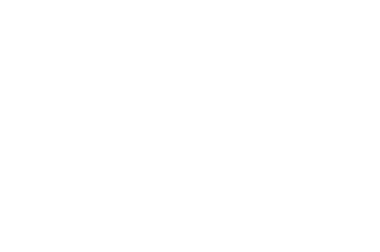

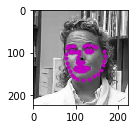

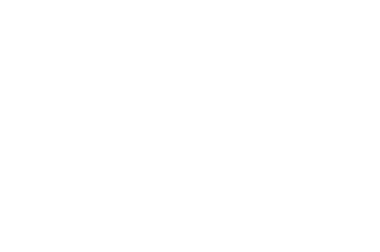

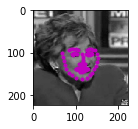

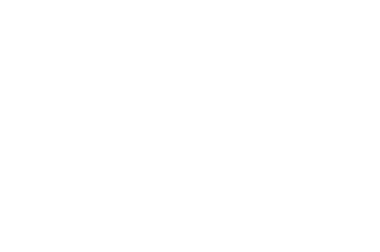

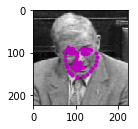

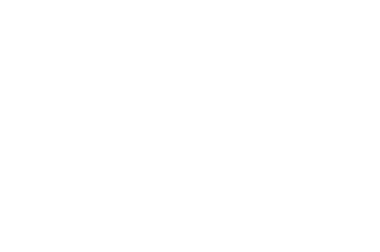

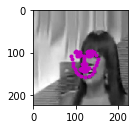

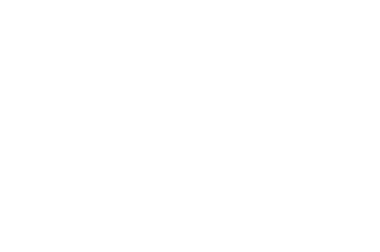

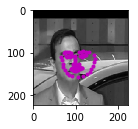

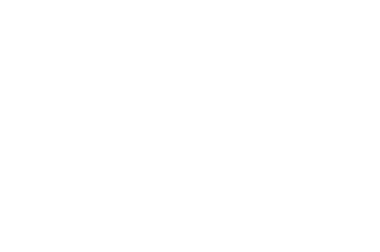

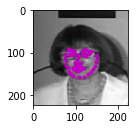

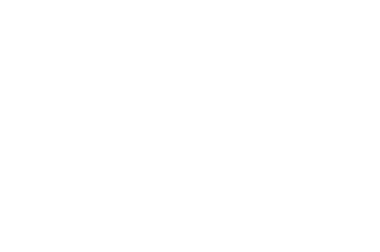

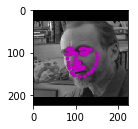

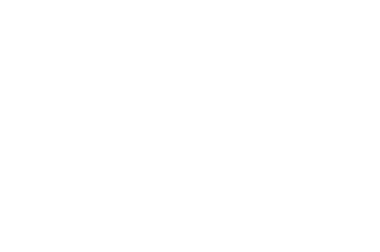

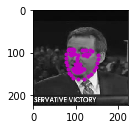

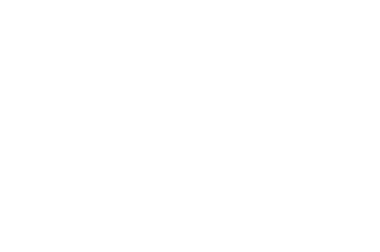

In [0]:
# calling the above function
visualize_output(ypred)

https://fairyonice.github.io/achieving-top-23-in-kaggles-facial-keypoints-detection-with-keras-tensorflow.html

In [0]:
hist2 = model2.fit(X_train, y_train, nb_epoch=200, batch_size=128, validation_split=0.2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 2769 samples, validate on 693 samples
Epoch 1/200
2769/2769 [==============================] - 13s 5ms/step - loss: 0.1773 - mean_absolute_error: 0.2677 - acc: 0.1253 - val_loss: 0.0280 - val_mean_absolute_error: 0.1321 - val_acc: 0.2468
Epoch 2/200
2769/2769 [==============================] - 9s 3ms/step - loss: 0.0258 - mean_absolute_error: 0.1258 - acc: 0.1961 - val_loss: 0.0181 - val_mean_absolute_error: 0.1048 - val_acc: 0.2410
Epoch 3/200
2769/2769 [==============================] - 9s 3ms/step - loss: 0.0182 - mean_absolute_error: 0.1048 - acc: 0.1968 - val_loss: 0.0148 - val_mean_absolute_error: 0.0939 - val_acc: 0.2857
Epoch 4/200
2769/2769 [==============================] - 9s 3ms/step - loss: 0.0151 - mean_absolute_error: 0.0949 - acc: 0.2300 - val_loss: 0.0126 - val_mean_absolute_error: 0.0861 - val_acc: 0.3175
Epoch 5/200
2769/2769 [==============================] - 9s 3ms/step - loss: 0.0131 - mean_absolute_error: 0.0879 - acc: 0.2430 - val_loss: 0.0119 - val_mea

KeyboardInterrupt: ignored

In [0]:
# Evaluate your model on the test images
# Score trained model.
scores = model2.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

770/770 [==============================] - 1s 2ms/step
Test loss: 0.009942748741089524
Test accuracy: 0.07493656873703003


In [0]:
#plotting the results
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Model Knowledge Check



### Question 1: What optimization and loss functions did you choose and why?


### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

### Playground


In [0]:
image_name = key_pts_frame.iloc[7,0]
im_7 = cv2.imread(os.path.join('/data/training/', image_name))

In [0]:
print(im_7.shape)

In [0]:
key_pts_7 = key_pts_frame.iloc[7,1:].values
key_pts_7 = key_pts_7.astype('float').reshape(-1,2)

In [0]:
org_h = im_7.shape[0]
org_w = im_7.shape[1]

In [0]:
from keras.preprocessing.image import load_img, img_to_array, save_img
im_rs = load_img(os.path.join('/data/training/', image_name), color_mode='grayscale', target_size=(224,224))

In [0]:
# Displaying a PIL image in Jupyter
from IPython.core.display import Image, display
display(im_rs)

In [0]:
print(key_pts_7[:5])

In [0]:
new_h = im_rs.size[0]
new_w = im_rs.size[1]
print(new_w)

In [0]:
print(key_pts_7[:5])

In [0]:
# scale the pts, too
key_pts_7 = key_pts_7 * [new_w / org_w, new_h / org_h]

In [0]:
plt.figure(figsize=(5, 5))
show_keypoints(im_rs, key_pts_7)
plt.show()

Testing resize function

In [0]:
image_name = key_pts_frame.iloc[0,0]

In [0]:
key_pts_0 = key_pts_frame.iloc[0,1:].values
key_pts_0 = key_pts_0.astype('float').reshape(-1,2)

In [0]:
im_0, key_pts_0 = resize_img(image_name, key_pts_0, 224)

In [0]:
plt.figure(figsize=(5, 5))
show_keypoints(im_rs, key_pts_7)
plt.show()

In [0]:
image_name = key_pts_frame.iloc[5,0]
im = cv2.imread(os.path.join('/data/training/', image_name))
im = cv2.resize(im, (224, 224))
if (im.shape[2] == 4):
  im = im[:,:,0:3]
im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
print(type(im))
print(im.shape)

In [0]:
from numpy import expand_dims, asarray
im = expand_dims(im, axis=2)
print(im.shape[3])

Saving our new rescaled and greyscaled image. We are missing one step. See if you can spot what we missed doing?

In [0]:
from keras.preprocessing.image import save_img
save_img('keras_gray_test.jpg', im)

In [0]:
from keras.preprocessing.image import load_img
im_gray = load_img('keras_gray_test.jpg')

In [0]:
from keras.preprocessing.image import load_img, img_to_array, save_img
im_gray = img_to_array(im_gray)

In [0]:
im_copy = np.copy(im_gray)
key_pts_5 = key_pts_frame.iloc[5,1:].values

In [0]:
# Grab the key_point values, convert them to a numpy.ndarray object. as_matrix() is deprecated.
key_points = key_pts_frame.iloc[5,1:].values

# convert the values to data type 'float' and give me a listing of the key points in [x,y] format.
#key_pts = key_pts.astype('float').reshape(-1, 2)
key_points = key_points.astype('float').reshape(68, 2)

plt.figure(figsize=(5, 5))
show_keypoints(im_gray, key_points)
plt.show()

In [0]:
im_gray.shape

In [0]:
from keras.preprocessing.image import load_img, img_to_array, save_img
from numpy import expand_dims, asarray

img = load_img(os.path.join('/data/training/', image_name), color_mode = 'grayscale', target_size=(224, 224))
data = asarray(img)
print(data.shape)
data_last = expand_dims(data, axis=2)
print(data_last.shape)
#img = expand_dims(img, axis=2)
#img_array = img_to_array(img)
# add in a channel. We need a dimension of 1 representing grayscale
#img_array = expand_dims(img, axis=2)
#img_array = img_array.reshape((224, 224, 1))
#save_img('keras_gray_test.jpg', img_array)

#img = load_img('keras_gray_test.jpg')
print(type(img))
#print(img.format)
#print(img.mode)
print(img.size)


#print(img_array.size)
#show_keypoints(img, key_pts)
#plt.show()


In [0]:
# Key_pts is our y
key_pts = key_pts_frame.iloc[5, 1:].values
key_pts = key_pts.astype('float').reshape(-1, 2)

In [0]:
plt.figure(figsize=(5, 5))
show_keypoints(im, key_pts)
plt.show()

In [0]:
# How many images do we have in the dataset? 
print('Number of images: ', len(key_pts_frame))

Let's create a function to draw the keypoints on top of each image. This will be somewhat similar to what we did in the previous lesson, by using the matplotlib library.



In [0]:
# Display a few different types of images by changing the index n

# select an image by index in our data frame
image_name = key_pts_frame.iloc[n, 0]
image = mpimg.imread(os.path.join('/data/training/', image_name))
if (image.shape[2] == 4):
  image = image[:,:,0:3]
sample = {'image': image, 'keypoints': key_pts}  
train_df.append(sample)
                     

# Key_pts is our y
key_pts = key_pts_frame.iloc[n, 1:].values
key_pts = key_pts.astype('float').reshape(-1, 2)

plt.figure(figsize=(5, 5))
show_keypoints(mpimg.imread(os.path.join('/data/training/', image_name)), key_pts)
plt.show()